# App1

*  An App with only 1 CPU-intensive function to validate the performance of the optimization algorithm
*  There is a self-loop in App1

In [1]:
import os
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from tqdm import tqdm
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
lambda_client = boto3.client('lambda')

In [3]:
function_prefix='ServerlessAppPerfOpt'

In [4]:
App_name = 'App1'

## Update all Functions in App1

### Types of workload

* Function 2: CPU Intensive
    * Factorial 28000

### Update Function Code

In [ ]:
functions=[]
for file in os.listdir('functions'):
    path=os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/'+file))
    if not file.startswith('.') and os.path.isdir(path):
        functions.append(file)
for function_folder in functions:
    buf = BytesIO()
    with zipfile.ZipFile(buf, 'w') as z:
        for file in os.listdir('functions/'+function_folder):
            z.write(os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))), os.path.basename(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))))
    buf.seek(0)
    pkg = buf.read()
    lambda_client.update_function_code(FunctionName='{}_{}'.format(function_prefix, function_folder),ZipFile=pkg)

### Update Function Memory and Timeout Configuration
* Available Memory Configurations: 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240, 2304, 2368, 2432, 2496, 2560, 2624, 2688, 2752, 2816, 2880, 2944, 3008


In [5]:
mem_config_list={
    'f2':128
}
timeout_config_list={
    'f2':60
}

In [ ]:
for function in mem_config_list.keys():
    lambda_client.update_function_configuration(FunctionName='{}_{}'.format(function_prefix, function), MemorySize=mem_config_list[function], Timeout=timeout_config_list[function])

### Test Run

#### Function 2

In [ ]:
lambda_client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f2'), InvocationType='Event')

## Execute Functions to Get the Performance Curve

* Run each function under each memory configuration for 100 times

In [8]:
available_mem_list=[128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240, 2304, 2368, 2432, 2496, 2560, 2624, 2688, 2752, 2816, 2880, 2944, 3008]

In [ ]:
for mem in available_mem_list:
    print('Memory: {} Timestamp: {} UTC: {}'.format(mem,time.time(),strftime("%d %b %Y %H:%M:%S +0000", gmtime())))
    mem_config={'f2':mem}
    for function in mem_config.keys():
        lambda_client.update_function_configuration(FunctionName='{}_{}'.format(function_prefix, function), MemorySize=mem_config[function])
    time.sleep(1)
    for i in tqdm(range(100)):
        time.sleep(10)
        lambda_client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f2'), InvocationType='Event')

## CloudWatch Logs

In [6]:
logclient = boto3.client('logs')

### Functions for parsing Logs

In [7]:
def lambda_report_log_to_dict(log):
    res={}
    lis=[item.split(': ') for item in log.split('\t')]
    res['RequestId']=lis[0][1]
    res['Duration']=float(lis[1][1].split(' ')[0])
    res['Billed Duration']=int(lis[2][1].split(' ')[0])
    res['Memory Size']=int(lis[3][1].split(' ')[0])
    res['Max Memory Used']=int(lis[4][1].split(' ')[0])
    return res

In [9]:
startTime=int(datetime.timestamp(datetime(year=2020,month=1,day=14,hour=22,minute=44,second=0,tzinfo=timezone.utc)))
endTime=int(datetime.timestamp(datetime(year=2020,month=1,day=15,hour=14,minute=30,second=0,tzinfo=timezone.utc)))

### Query Logs

#### Function 2

In [9]:
query_f2 = logclient.start_query(
    logGroupName='/aws/lambda/{}_{}'.format(function_prefix, 'f2'),
    queryString="fields @timestamp, @message| filter @message like 'REPORT'| sort @timestamp desc",
    startTime=startTime,
    endTime=endTime,
    limit=10000
)

In [10]:
query_results_f2 = logclient.get_query_results(
    queryId=query_f2['queryId']
)

In [11]:
f2_log_list=[lambda_report_log_to_dict(item [1]['value']) for item in query_results_f2['results']]

In [12]:
len(f2_log_list)

4600

#### Convert Logs into DataFrame and Save as CSV

In [14]:
for item in f2_log_list:
    item['Function']='f2'
App1_Lambda_Logs=pd.DataFrame(f2_log_list)
App1_Lambda_Logs.index=range(App1_Lambda_Logs.shape[0])
App1_Lambda_Logs=App1_Lambda_Logs[['Function', 'Memory Size', 'Max Memory Used', 'Duration', 'Billed Duration', 'RequestId']]
App1_Lambda_Logs.to_csv('App1_Lambda_Logs.csv',index=False)

In [10]:
App1_Lambda_Logs = pd.read_csv('App1_Lambda_Logs.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
App1_Lambda_Logs.columns = ['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'RequestId']

In [11]:
App1_Lambda_Logs.head()

,Function,Memory_Size,Max_Memory_Used,Duration,Billed_Duration,RequestId
0,f2,3008,61,201.37,300,e248bb58-5eb1-4c28-a267-6d960abec62d
1,f2,3008,61,201.22,300,8c7d1e64-067c-4eff-91ec-54ccd513b2b1
2,f2,3008,61,204.05,300,1857d1bd-aa8c-4c92-aa96-d61ea3829009
3,f2,3008,61,201.03,300,d1d1e879-b5d3-4611-9270-cb9344731190
4,f2,3008,61,199.64,200,7b239d7c-3374-49a3-8f96-2d759fab2ed0


## Performance Curve

In [12]:
f2_duration = [App1_Lambda_Logs.query("Function == {} and Memory_Size == {}".format("'f2'",mem))['Duration'].mean() for mem in available_mem_list]

In [13]:
f2_perf_profile = dict(zip(available_mem_list, f2_duration))

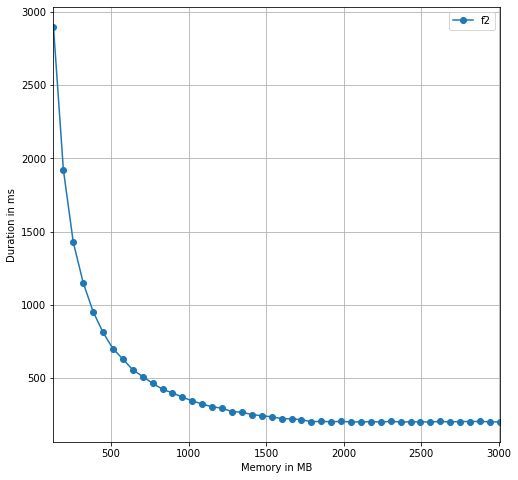

In [14]:
fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)
ax.grid()
ax.set_xlim(128,3008)
ax.plot(available_mem_list, f2_duration, marker='o', label='f2') 
ax.legend()
ax.set_xlabel('Memory in MB')
ax.set_ylabel('Duration in ms')
fig.savefig('App1_Performance_Curve', dpi=300)
fig.savefig('App1_Performance_Curve.pdf')

## Performance Cost Table

### Import Libraries

In [15]:
import sys
sys.path.append('../../../source/ServerlessAppPerfCostMdlOpt')
import networkx as nx
import itertools
import warnings
warnings.filterwarnings("ignore")
from ServerlessAppWorkflow import ServerlessAppWorkflow
from AppGenerator import AppGenerator
from PerfOpt import PerfOpt

### Sample Performance Curve

Sampled Memory List: [128, 320, 512, 704, 896, 1088, 1280, 1472, 1664, 1856, 2048, 2240, 2432, 2624, 2816, 3008]
Length of the Sampled Memory List: 16
Number of Configurations in App1 after Sampling: 16


Text(0, 0.5, 'Duration in ms')

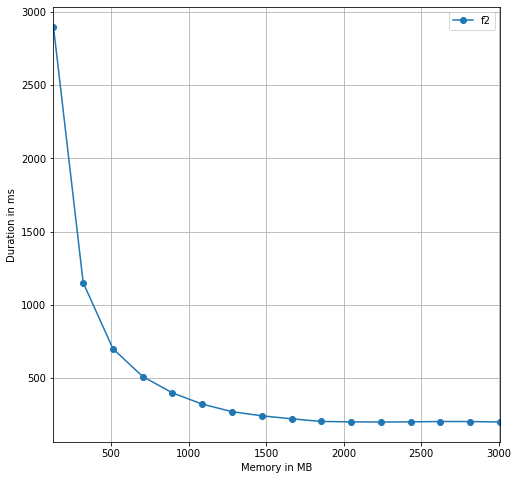

In [16]:
sampled_mem_list = list(range(128, 3072, 192))
number_of_configurations = np.power(len(sampled_mem_list),1)
print('Sampled Memory List:', sampled_mem_list)
print('Length of the Sampled Memory List:', len(sampled_mem_list))
print('Number of Configurations in App1 after Sampling:', number_of_configurations)

fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)
ax.grid()
ax.set_xlim(128,3008)
ax.plot(list(range(128, 3072, 192)), f2_duration[0:46:3], marker='o', label='f2') 
ax.legend()
ax.set_xlabel('Memory in MB')
ax.set_ylabel('Duration in ms')

### Get Performance Cost Table

#### Define App Orchestration

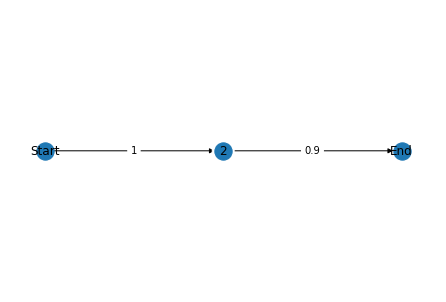

CompletedProcess(args=['dot', '-n', '-Tpng', 'App1_G.dot'], returncode=0)

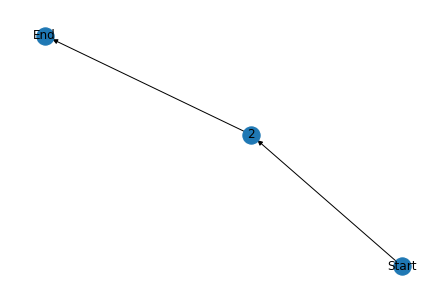

In [40]:
App1_G = nx.DiGraph()
App1_G.add_node('Start', pos=(0, 1))
App1_G.add_node(2, pos=(1, 1), perf_profile={mem:f2_perf_profile[mem] for mem in sampled_mem_list})
App1_G.add_node('End', pos=(2, 1))
App1_G.add_weighted_edges_from([('Start', 2, 1), (2, 2, 0.1), (2, 'End', 0.9)])
pos_App1_G = nx.get_node_attributes(App1_G, 'pos')
nx.draw(App1_G, pos_App1_G, with_labels=True)
labels_App1_G = nx.get_edge_attributes(App1_G, 'weight')
nx.draw_networkx_edge_labels(App1_G, pos_App1_G, edge_labels=labels_App1_G)
pos_higher_offset_App1_G = {}
for k, v in pos_App1_G.items():
    pos_higher_offset_App1_G[k] = (v[0], v[1] + 0.15)
plt.show()

# Generate workflow PNG
# import subprocess
# nx.draw(App1_G, with_labels=True)
# nx.nx_agraph.write_dot(App1_G,'App1_G.dot')
# f = open("App1_G.png", "w")
# subprocess.run(["dot", "-n", "-Tpng", "App1_G.dot"],stdout=f)

#### Define the number of workers

In [18]:
number_of_workers = 1

#### Define the data storage location

In [19]:
pct_data_folder = 'perf_cost_data'

#### Generate Workload

In [20]:
pct_filename_list = [pct_data_folder + '/' + App_name+'_part'+str(n) +'.csv' for n in range(1,number_of_workers+1)]
pct_start_iterations_list = [int(number_of_configurations/number_of_workers * (n-1))+1 for n in range(1,number_of_workers+1)]
pct_end_iterations_list = [n-1 for n in pct_start_iterations_list[1:]]
pct_end_iterations_list.append(number_of_configurations)

#### Run Algorithms to get the table

In [21]:
def pct_work(App_G, filename, start_iterations, end_iterations):
    App = ServerlessAppWorkflow(G=App_G.copy())
    optimizer = PerfOpt(App, generate_perf_profile=False)
    optimizer.get_perf_cost_table(file=filename, start_iterations=start_iterations, end_iterations=end_iterations)

In [22]:
from multiprocessing import Process
p = Process(target=pct_work, args=(App1_G, pct_filename_list[0], pct_start_iterations_list[0], pct_end_iterations_list[0],))
p.start()

Get Performance Cost Table - Task Size: 16


100%|██████████| 16/16 [00:00<00:00, 276.11it/s]


### Process Performance Cost Table

In [23]:
perf_cost_data = pd.DataFrame()
for filename in pct_filename_list:
    data_parts = pd.read_csv(filename, error_bad_lines=False, warn_bad_lines=False,low_memory=False)
    perf_cost_data = perf_cost_data.append(data_parts)
perf_cost_data = perf_cost_data[['2','Cost','RT']]
perf_cost_data.columns=['f2','Cost','RT']
perf_cost_data.index=range(1,perf_cost_data.shape[0]+1)
perf_cost_data.head()

,f2,Cost,RT
1,128.0,6.924444,3300.684333
2,320.0,7.168889,1359.026111
3,512.0,7.635556,858.667778
4,704.0,7.862222,647.873556
5,896.0,6.706667,523.817444


In [24]:
minimal_cost = perf_cost_data['Cost'].min()
maximal_cost = perf_cost_data['Cost'].max()
minimal_rt = perf_cost_data['RT'].min()
maximal_rt = perf_cost_data['RT'].max()
print('Minimal Cost: ', minimal_cost, 'per 1 million executions')
print('Maximal Cost: ', maximal_cost, 'per 1 million executions')
print('Minimal RT: ', minimal_rt, 'ms')
print('Maximal RT: ', maximal_rt, 'ms')

Minimal Cost:  6.706666666666666 per 1 million executions
Maximal Cost:  16.545555555555556 per 1 million executions
Minimal RT:  302.985 ms
Maximal RT:  3300.684333333332 ms


## Optimization Curve

### Get Optimization Curve Data

#### Define Parameters

In [25]:
App1_ocd_budget_num_of_points = 100
App1_ocd_performance_constraint_num_of_points = 100
App1_ocd_filenameprefix = 'opt_curve_data/App1'

In [26]:
def ocd_work(App_G, filenameprefix, budget_num, performance_constraint_num):
    App = ServerlessAppWorkflow(G=App_G.copy())
    optimizer = PerfOpt(App, generate_perf_profile=False)
    optimizer.get_opt_curve(filenameprefix=filenameprefix, budget_list=list(np.linspace(optimizer.minimal_cost, optimizer.maximal_cost, budget_num)), performance_constraint_list=list(np.linspace(optimizer.minimal_avg_rt, optimizer.maximal_avg_rt, performance_constraint_num)))

#### Run Algorithms to get the curve

In [27]:
%%capture
ocd_work(App1_G, App1_ocd_filenameprefix, App1_ocd_budget_num_of_points, App1_ocd_performance_constraint_num_of_points)

### Process Optimization Curve Data

In [28]:
opt_curve_data_BPBC = pd.read_csv(App1_ocd_filenameprefix+'_BPBC.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
opt_curve_data_BPBC = opt_curve_data_BPBC.assign(Best_Answer_RT=lambda opt_curve_data_BPBC: opt_curve_data_BPBC[['BCR_disabled_RT', 'BCR_RT/M_RT', 'BCR_ERT/C_RT', 'BCR_MAX_RT']].min(1))
opt_curve_data_BCPC = pd.read_csv(App1_ocd_filenameprefix+'_BCPC.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
opt_curve_data_BCPC = opt_curve_data_BCPC.assign(Best_Answer_Cost=lambda opt_curve_data_BCPC: opt_curve_data_BCPC[['BCR_disabled_Cost', 'BCR_M/RT_Cost', 'BCR_C/ERT_Cost', 'BCR_MAX_Cost']].min(1))

In [29]:
opt_curve_data_BPBC.head(2)

,Budget,BCR_disabled_RT,BCR_RT/M_RT,BCR_ERT/C_RT,BCR_MAX_RT,BCR_disabled_Cost,BCR_RT/M_Cost,BCR_ERT/C_Cost,BCR_MAX_Cost,BCR_disabled_Config,BCR_RT/M_Config,BCR_ERT/C_Config,BCR_MAX_Config,BCR_disabled_Iterations,BCR_RT/M_Iterations,BCR_ERT/C_Iterations,BCR_MAX_Iterations,BCR_threshold,Best_Answer_RT
0,6.924444,523.817444,523.817444,3300.684333,523.817444,6.706667,6.706667,6.924444,6.706667,{2: 896},{2: 896},{2: 128},{2: 896},2.0,2.0,1.0,2.0,0.2,523.817444
1,7.021627,523.817444,523.817444,3300.684333,523.817444,6.706667,6.706667,6.924444,6.706667,{2: 896},{2: 896},{2: 128},{2: 896},2.0,2.0,1.0,2.0,0.2,523.817444


In [30]:
opt_curve_data_BCPC.head(2)

,Performance_Constraint,BCR_disabled_RT,BCR_M/RT_RT,BCR_C/ERT_RT,BCR_MAX_RT,BCR_disabled_Cost,BCR_M/RT_Cost,BCR_C/ERT_Cost,BCR_MAX_Cost,BCR_disabled_Config,BCR_M/RT_Config,BCR_C/ERT_Config,BCR_MAX_Config,BCR_disabled_Iterations,BCR_M/RT_Iterations,BCR_C/ERT_Iterations,BCR_MAX_Iterations,BCR_threshold,Best_Answer_Cost
0,303.323556,302.985000,302.985000,302.985000,302.985000,12.378889,12.378889,12.378889,12.378889,{2: 2240},{2: 2240},{2: 2240},{2: 2240},2.0,2.0,2.0,2.0,0.2,12.378889
1,333.599927,327.431444,327.431444,327.431444,327.431444,9.252222,9.252222,9.252222,9.252222,{2: 1664},{2: 1664},{2: 1664},{2: 1664},2.0,2.0,2.0,4.0,0.2,9.252222


In [31]:
best_rt = [perf_cost_data.query("Cost<={}".format(item))['RT'].min() for item in opt_curve_data_BPBC['Budget']]
best_cost = [perf_cost_data.query("RT<={}".format(item))['Cost'].min() for item in opt_curve_data_BCPC['Performance_Constraint']]
BPBC_accuracy = 100-(opt_curve_data_BPBC['Best_Answer_RT']-best_rt)/opt_curve_data_BPBC['Best_Answer_RT']*100
BCPC_accuracy = 100-(opt_curve_data_BCPC['Best_Answer_Cost']-best_cost)/opt_curve_data_BCPC['Best_Answer_Cost']*100

In [37]:
with open('results.json', 'w', encoding='utf-8') as f:
    json.dump({
               "BPBC_BCR_disabled_Iterations":opt_curve_data_BPBC["BCR_disabled_Iterations"].mean(),
               "BPBC_BCR_RT/M_Iterations":opt_curve_data_BPBC["BCR_RT/M_Iterations"].mean(),
               "BPBC_BCR_ERT/C_Iterations":opt_curve_data_BPBC["BCR_ERT/C_Iterations"].mean(),
               "BPBC_BCR_MAX_Iterations":opt_curve_data_BPBC["BCR_MAX_Iterations"].mean(),
               "BCPC_BCR_disabled_Iterations":opt_curve_data_BCPC["BCR_disabled_Iterations"].mean(),
               "BCPC_BCR_M/RT_Iterations":opt_curve_data_BCPC["BCR_M/RT_Iterations"].mean(),
               "BCPC_BCR_C/ERT_Iterations":opt_curve_data_BCPC["BCR_C/ERT_Iterations"].mean(),
               "BCPC_BCR_MAX_Iterations":opt_curve_data_BCPC["BCR_MAX_Iterations"].mean()
              }, f, ensure_ascii=False, indent=4)

### BPBC Problem

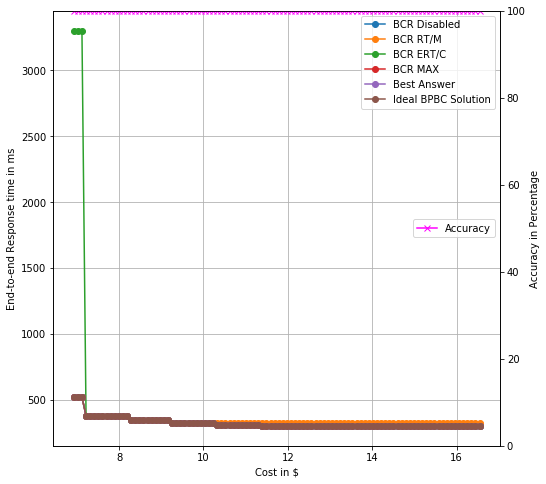

In [38]:
fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)
ax.grid()
ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['BCR_disabled_RT'], marker='o', label='BCR Disabled')
ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['BCR_RT/M_RT'], marker='o', label='BCR RT/M') 
ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['BCR_ERT/C_RT'], marker='o', label='BCR ERT/C') 
ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['BCR_MAX_RT'], marker='o', label='BCR MAX') 
ax.plot(opt_curve_data_BPBC['Budget'], opt_curve_data_BPBC['Best_Answer_RT'] , marker='o', label='Best Answer') 
ax.plot(opt_curve_data_BPBC['Budget'], best_rt, marker='o', label='Ideal BPBC Solution') 
ax.legend()
ax.set_xlabel('Cost in $')
ax.set_ylabel('End-to-end Response time in ms')
ax2 = ax.twinx()
ax2.plot(opt_curve_data_BPBC['Budget'], BPBC_accuracy, marker = 'x', label='Accuracy', color='magenta')
ax2.legend(loc='center right')
ax2.set_ylim(0,100)
ax2.set_ylabel('Accuracy in Percentage')
fig.savefig('App1_Optimization_Curve_BPBC', dpi=300)
fig.savefig('App1_Optimization_Curve_BPBC.pdf')

### BCPC Problem

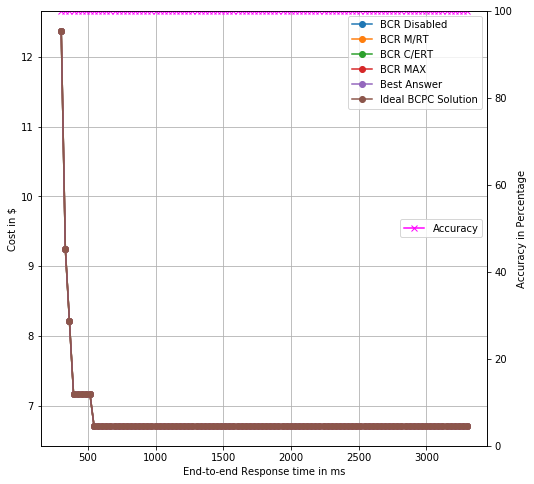

In [39]:
fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)
ax.grid()
ax.plot(opt_curve_data_BCPC['Performance_Constraint'], opt_curve_data_BCPC['BCR_disabled_Cost'], marker='o', label='BCR Disabled')
ax.plot(opt_curve_data_BCPC['Performance_Constraint'], opt_curve_data_BCPC['BCR_M/RT_Cost'], marker='o', label='BCR M/RT') 
ax.plot(opt_curve_data_BCPC['Performance_Constraint'], opt_curve_data_BCPC['BCR_C/ERT_Cost'], marker='o', label='BCR C/ERT') 
ax.plot(opt_curve_data_BCPC['Performance_Constraint'], opt_curve_data_BCPC['BCR_MAX_Cost'], marker='o', label='BCR MAX') 
ax.plot(opt_curve_data_BCPC['Performance_Constraint'], opt_curve_data_BCPC['Best_Answer_Cost'] , marker='o', label='Best Answer') 
ax.plot(opt_curve_data_BCPC['Performance_Constraint'], best_cost, marker='o', label='Ideal BCPC Solution') 
ax.legend()
ax.set_xlabel('End-to-end Response time in ms')
ax.set_ylabel('Cost in $')
ax2 = ax.twinx()
ax2.plot(opt_curve_data_BCPC['Performance_Constraint'], BCPC_accuracy, marker = 'x', label='Accuracy', color='magenta')
ax2.legend(loc='center right')
ax2.set_ylim(0,100)
ax2.set_ylabel('Accuracy in Percentage')
fig.savefig('App1_Optimization_Curve_BCPC', dpi=300)
fig.savefig('App1_Optimization_Curve_BCPC.pdf')